In [2]:
import os
import sys
def getRepoPath():
    cwd = os.getcwd()
    delimiter = "\\" if "\\" in cwd else "/"
    repoPath = delimiter.join(cwd.split(delimiter)[:cwd.split(delimiter).index("dataImport")]) + delimiter
    return repoPath
repoPath = getRepoPath()
sys.path.append(repoPath + 'dataImport/')
from utils import workingDataPath, getWorkingHRDfParquet, getHRGroups

import pandas as pd
import matplotlib.pyplot as plt


AppleWatchHRDf = getWorkingHRDfParquet('apple')

Text(0.5, 0, 'BPM')

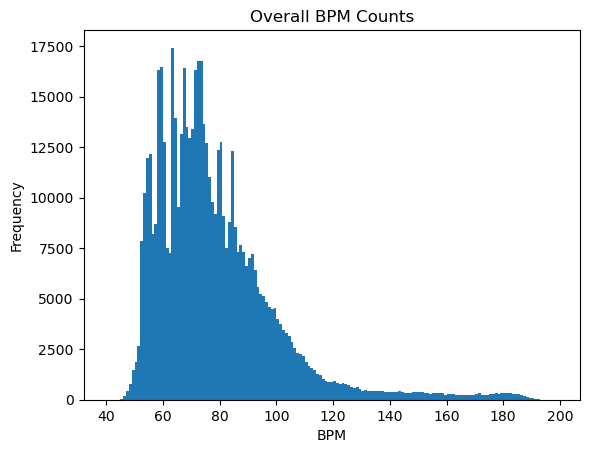

In [3]:
ax = AppleWatchHRDf.value.plot.hist(bins=[x for x in range(40,200)], title="Overall BPM Counts")
ax.set_xlabel("BPM")


In [89]:
#output cols HR seconds
def timeBalancedHRHist(HRDf, maxInterval):
    #get min and max HR
    minHR = 30
    maxHR = 210
    # HRDF
    HRDfCopy = HRDf.copy()
    # calc between measures
    timeSeries = pd.Series(HRDf.index)
    bm = pd.Series(index=HRDf.index, data = (timeSeries.shift(-1) - timeSeries).dt.total_seconds().values)
    HRDfCopy['betweenMeasures'] = bm
    # the last value will be nan so replace it with the max interval
    HRDfCopy['betweenMeasures'] = HRDfCopy['betweenMeasures'].fillna(maxInterval)
    # if above thershold set to max
    HRDfCopy[HRDfCopy['betweenMeasures'] > maxInterval] = maxInterval
    
    data = []
    # for every heartrate in the range
    for hr in range(minHR, maxHR + 1):
        # sum the thersholded between measures
        totalTime = HRDfCopy[HRDfCopy['value'] == hr].betweenMeasures.sum()
        data.append([hr, totalTime])
        # if hr == 140:
            # print(f"number of samples for {hr} is {len(HRDfCopy[HRDfCopy['value'] == hr])}")
            # print(f"the average between measures is {HRDfCopy[HRDfCopy['value'] == hr].betweenMeasures.mean()}")
    return pd.DataFrame(data=data, columns=['hr', 'seconds'])

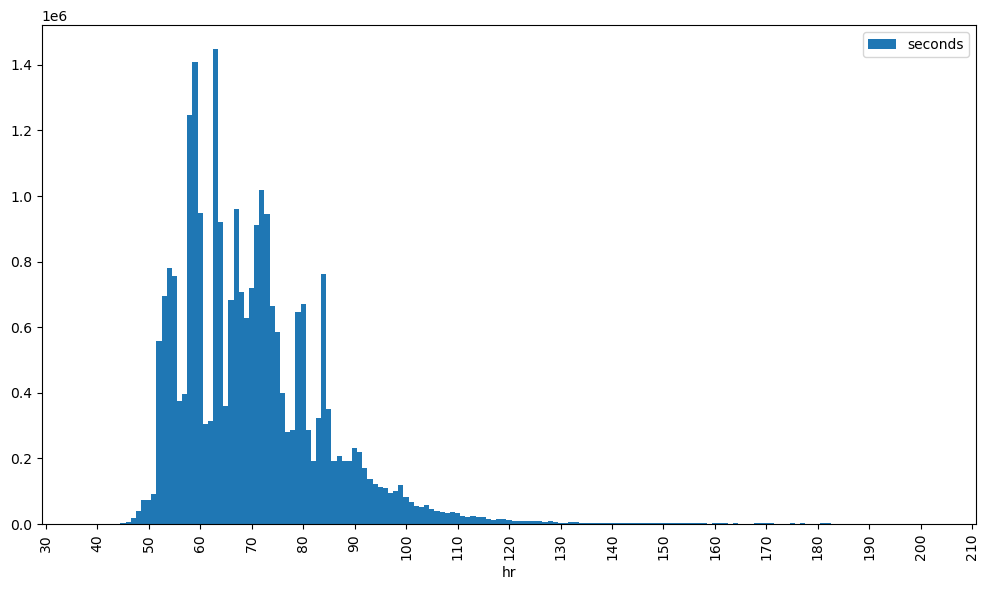

In [90]:
import matplotlib.pyplot as plt
tbDF = timeBalancedHRHist(AppleWatchHRDf, 300)
tbDF.plot(kind='bar', y='seconds', x='hr', figsize=(10,6), linewidth=0.0,width=1)
plt.xticks(ticks=range(0, len(tbDF), 10), labels=tbDF['hr'][::10])
# Show the plot
plt.tight_layout()
plt.show()

In [34]:
tbDF

,hr,seconds
0,38,300.0
1,39,0.0
2,40,300.0
3,41,300.0
4,42,2100.0
...,...,...
156,194,0.0
157,195,0.0
158,196,0.0
159,197,300.0


In [3]:
AppleWatchHRDf

,value
sampleDT,
2021-07-19 19:55:06-07:00,78.0
2021-07-19 19:55:11-07:00,79.0
2021-07-19 19:55:14-07:00,80.0
2021-07-19 19:55:21-07:00,82.0
2021-07-19 19:55:23-07:00,83.0
...,...
2024-09-17 12:53:00-07:00,70.0
2024-09-17 12:53:07-07:00,70.0
2024-09-17 12:53:14-07:00,72.0


In [4]:
AppleWatchHRDf = AppleWatchHRDf.sort_index()

In [5]:
timesSeries = pd.Series(AppleWatchHRDf.index)

In [6]:
betweenMesures = ((timesSeries.shift(-1) - timesSeries)).astype('timedelta64[s]')

In [7]:
betweenMesures

0        0 days 00:00:05
1        0 days 00:00:03
2        0 days 00:00:07
3        0 days 00:00:02
4        0 days 00:00:07
               ...      
567890   0 days 00:00:07
567891   0 days 00:00:07
567892   0 days 00:00:03
567893   0 days 00:00:07
567894               NaT
Name: sampleDT, Length: 567895, dtype: timedelta64[s]

In [8]:
AppleWatchHRDf["timeToNextReading"] = pd.Series(index=AppleWatchHRDf.index, data=betweenMesures.values)

In [9]:
betweenMesures = betweenMesures.dropna()

In [10]:
AppleWatchHRDf = AppleWatchHRDf.dropna()

In [11]:
AppleWatchHRDf

,value,timeToNextReading
sampleDT,,
2021-07-19 19:55:06-07:00,78.0,0 days 00:00:05
2021-07-19 19:55:11-07:00,79.0,0 days 00:00:03
2021-07-19 19:55:14-07:00,80.0,0 days 00:00:07
2021-07-19 19:55:21-07:00,82.0,0 days 00:00:02
2021-07-19 19:55:23-07:00,83.0,0 days 00:00:07
...,...,...
2024-09-17 12:52:58-07:00,69.0,0 days 00:00:02
2024-09-17 12:53:00-07:00,70.0,0 days 00:00:07
2024-09-17 12:53:07-07:00,70.0,0 days 00:00:07


In [12]:
betweenMesures = betweenMesures.sort_values()

In [18]:
betweenMesures = betweenMesures.dt.total_seconds()

Text(0.5, 0, 'Interval (sec)')

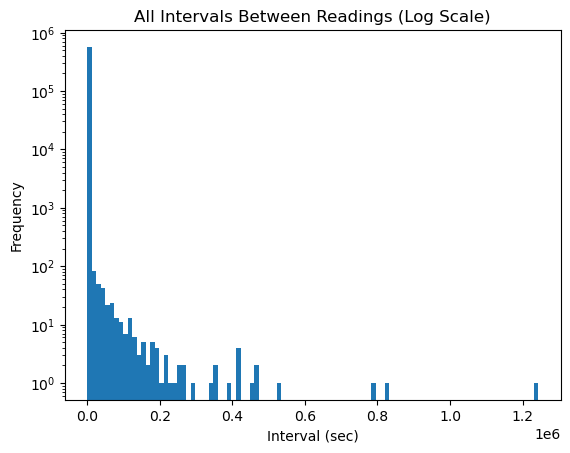

In [19]:
ax = betweenMesures.plot.hist(bins=100, log=True, title="All Intervals Between Readings (Log Scale)")
ax.set_xlabel("Interval (sec)")

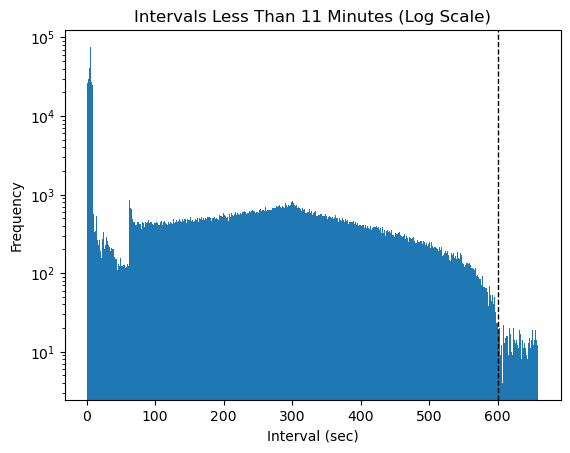

In [20]:
ax = betweenMesures.loc[betweenMesures<660].plot.hist(bins=659, log=True, title="Intervals Less Than 11 Minutes (Log Scale)")
ax.set_xlabel("Interval (sec)")
ax.axvline(600, color='k', linestyle='dashed', linewidth=1)

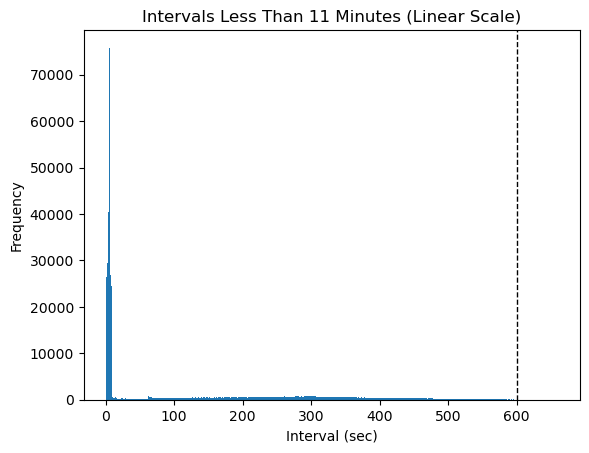

In [21]:
ax = betweenMesures.loc[betweenMesures<660].plot.hist(bins=659, title="Intervals Less Than 11 Minutes (Linear Scale)")
ax.set_xlabel("Interval (sec)")
ax.axvline(600, color='k', linestyle='dashed', linewidth=1)

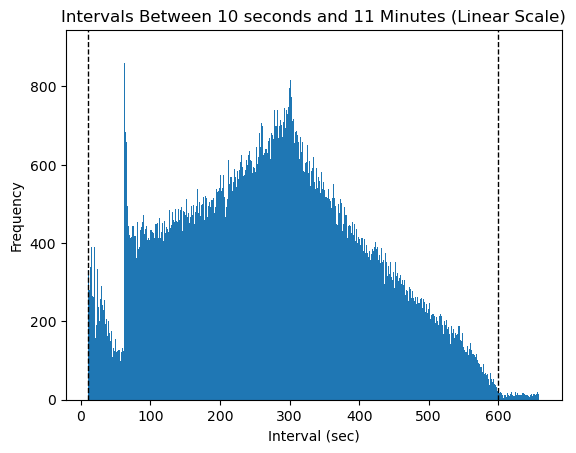

In [22]:
ax = betweenMesures.loc[betweenMesures<660].loc[betweenMesures>10].plot.hist(bins=648, title="Intervals Between 10 seconds and 11 Minutes (Linear Scale)")
ax.set_xlabel("Interval (sec)")
ax.axvline(10, color='k', linestyle='dashed', linewidth=1)
ax.axvline(600, color='k', linestyle='dashed', linewidth=1)

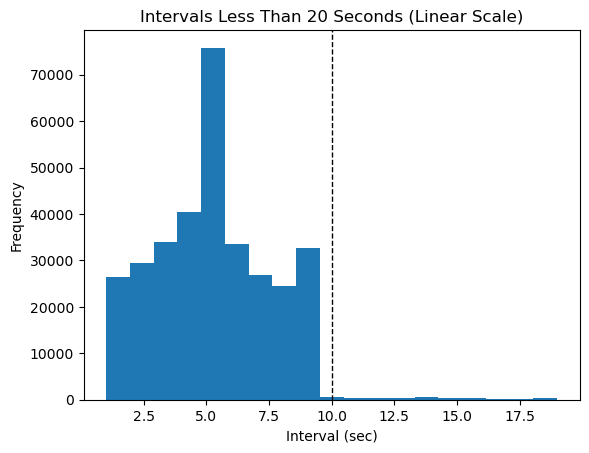

In [23]:
ax = betweenMesures.loc[betweenMesures<20].plot.hist(bins=19, title="Intervals Less Than 20 Seconds (Linear Scale)")
ax.set_xlabel("Interval (sec)")
ax.axvline(10, color='k', linestyle='dashed', linewidth=1)

In [19]:
betweenMesures.describe()

count    3.713570e+05
mean     2.640582e+02
std      4.355975e+03
min      1.000000e+00
25%      6.000000e+00
50%      1.630000e+02
75%      3.170000e+02
max      1.242634e+06
Name: sampleDT, dtype: float64

In [20]:
AppleWatchHRDf[AppleWatchHRDf["timeToNextReading"] < 10].value.describe()

count    128662.000000
mean        101.450251
std          26.735434
min          42.000000
25%          84.000000
50%          95.000000
75%         110.000000
max         198.000000
Name: value, dtype: float64

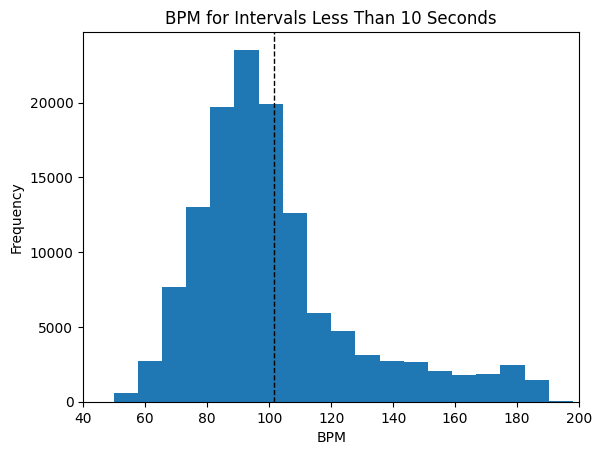

In [21]:
workOutBPMdf = AppleWatchHRDf[AppleWatchHRDf["timeToNextReading"] < 10]
ax = workOutBPMdf.value.plot.hist(bins=20, xlim=(40,200), title="BPM for Intervals Less Than 10 Seconds")
ax.set_xlabel("BPM")
ax.axvline(AppleWatchHRDf[AppleWatchHRDf["timeToNextReading"] < 10].value.mean(), color='k', linestyle='dashed', linewidth=1)

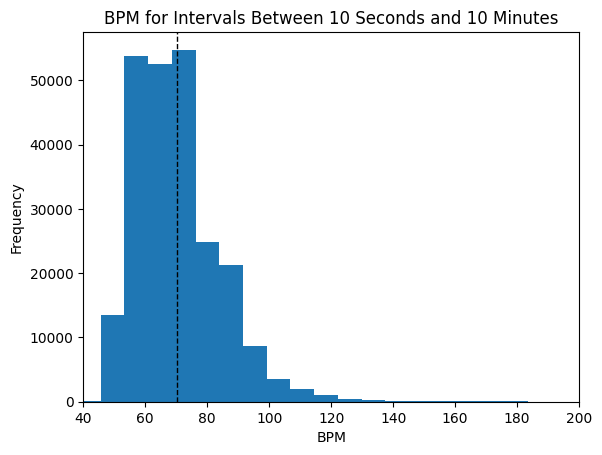

In [22]:
standByBPMdf = AppleWatchHRDf.loc[(AppleWatchHRDf["timeToNextReading"] >= 10) &
                        (AppleWatchHRDf["timeToNextReading"] < 600)]

ax = standByBPMdf.value.plot.hist(bins=20, xlim=(40,200), title="BPM for Intervals Between 10 Seconds and 10 Minutes")
ax.set_xlabel("BPM")
ax.axvline(standByBPMdf.value.mean(), color='k', linestyle='dashed', linewidth=1)

(30.0, 220.0)

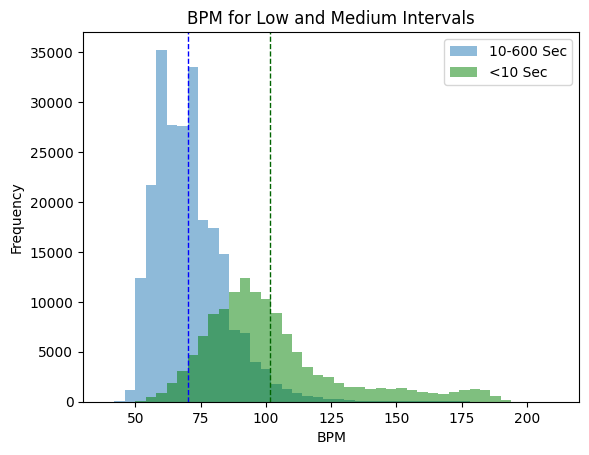

In [30]:
# plt.hist()
ax = standByBPMdf.value.plot.hist(bins=[x for x in range(30,221, (220-30)//40)], xlim=(30,200), alpha=0.5, label="10-600 Sec", title="BPM for Low and Medium Intervals")
ax.hist(workOutBPMdf.value, bins=[x for x in range(30,221, (220-30)//40)], alpha=0.5, color="g", label="<10 Sec")
ax.set_xlabel("BPM")
ax.axvline(standByBPMdf.value.mean(), color='b', linestyle='dashed', linewidth=1)
ax.axvline(workOutBPMdf.value.mean(), color='darkgreen', linestyle='dashed', linewidth=1)
ax.legend(loc='upper right') 
ax.set_xlim(30,220)

In [5]:
from collections import OrderedDict
minGroupTime = pd.Timedelta(seconds=1)

dataod = OrderedDict()
for maxDelta in range(1,800+1):
    hrGroups = getHRGroups(AppleWatchHRDf, maxDelta, minGroupTime)
    hrGroupDurations = [(g[1]-g[0]).total_seconds() for g in hrGroups]
    dataod[maxDelta] = hrGroupDurations
    print(f"generated {len(dataod)} groups")

generated 1 groups
generated 2 groups
generated 3 groups
generated 4 groups
generated 5 groups
generated 6 groups
generated 7 groups
generated 8 groups
generated 9 groups
generated 10 groups
generated 11 groups
generated 12 groups
generated 13 groups
generated 14 groups
generated 15 groups
generated 16 groups
generated 17 groups
generated 18 groups
generated 19 groups
generated 20 groups
generated 21 groups
generated 22 groups
generated 23 groups
generated 24 groups
generated 25 groups
generated 26 groups
generated 27 groups
generated 28 groups
generated 29 groups
generated 30 groups
generated 31 groups
generated 32 groups
generated 33 groups
generated 34 groups
generated 35 groups
generated 36 groups
generated 37 groups
generated 38 groups
generated 39 groups
generated 40 groups
generated 41 groups
generated 42 groups
generated 43 groups
generated 44 groups
generated 45 groups
generated 46 groups
generated 47 groups
generated 48 groups
generated 49 groups
generated 50 groups
generated

Text(0.5, 0, 'maxDelta')

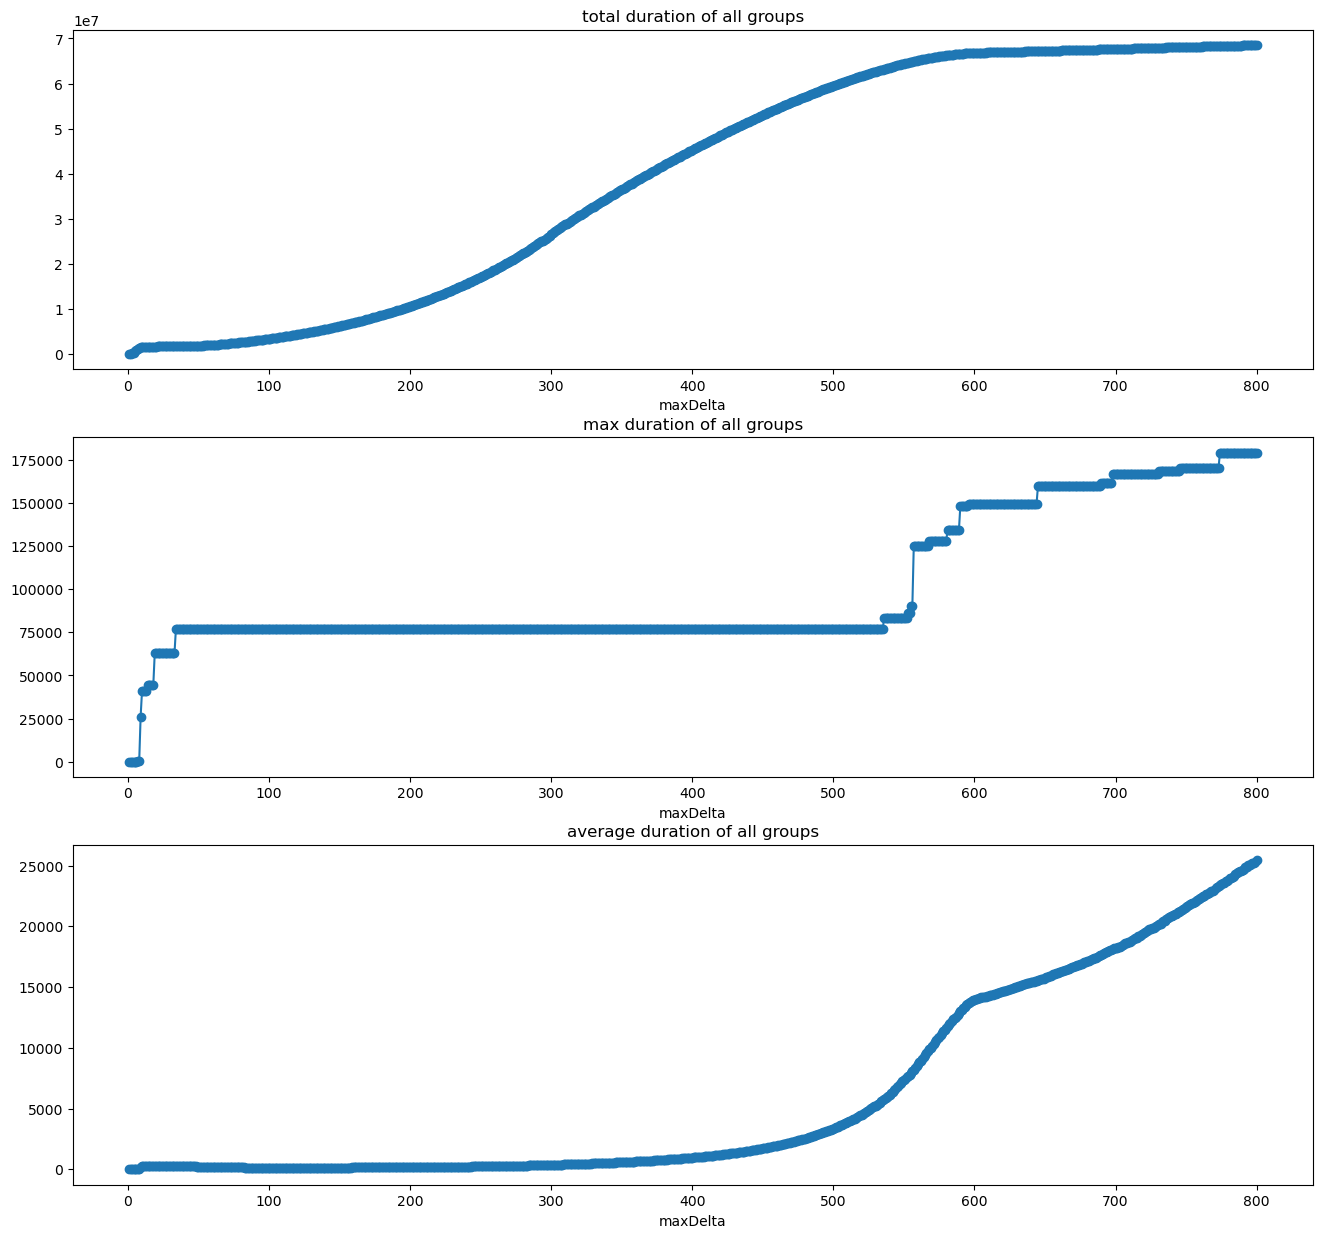

In [6]:

total_durations = [sum(dataod[key]) for key in dataod]
longest_durations = [max(dataod[key]) for key in dataod]
average_durations = [sum(dataod[key]) / len(dataod[key]) for key in dataod]
fig, axs = plt.subplots(3, 1, figsize=(16, 15))
axs[0].set_title('total duration of all groups')
axs[0].plot(list(dataod.keys()), total_durations, marker='o')
axs[0].set_xlabel('maxDelta')
axs[1].set_title('max duration of all groups')
axs[1].plot(list(dataod.keys()), longest_durations, marker='o')
axs[1].set_xlabel('maxDelta')
axs[2].set_title('average duration of all groups')
axs[2].plot(list(dataod.keys()), average_durations, marker='o')
axs[2].set_xlabel('maxDelta')

Text(0.5, 0, 'maxDelta')

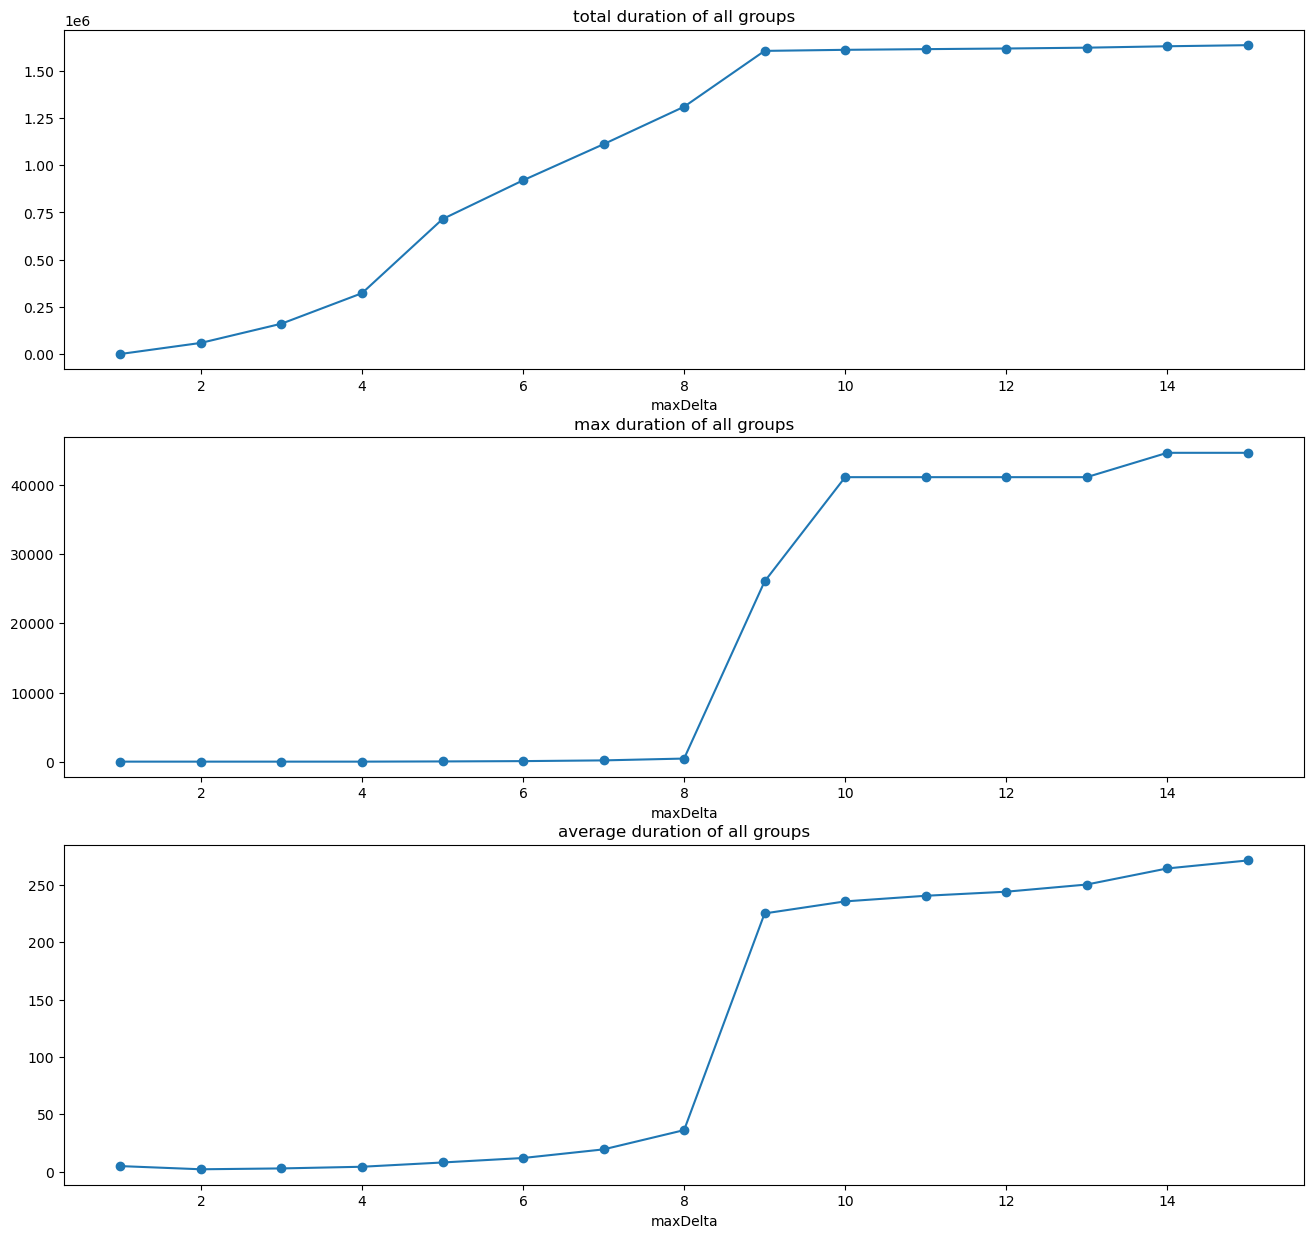

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(16, 15))
axs[0].set_title('total duration of all groups')
axs[0].plot(list(dataod.keys())[:15], total_durations[:15], marker='o')
axs[0].set_xlabel('maxDelta')
axs[1].set_title('max duration of all groups')
axs[1].plot(list(dataod.keys())[:15], longest_durations[:15], marker='o')
axs[1].set_xlabel('maxDelta')
axs[2].set_title('average duration of all groups')
axs[2].plot(list(dataod.keys())[:15], average_durations[:15], marker='o')
axs[2].set_xlabel('maxDelta')

Text(0.5, 0, 'maxDelta')

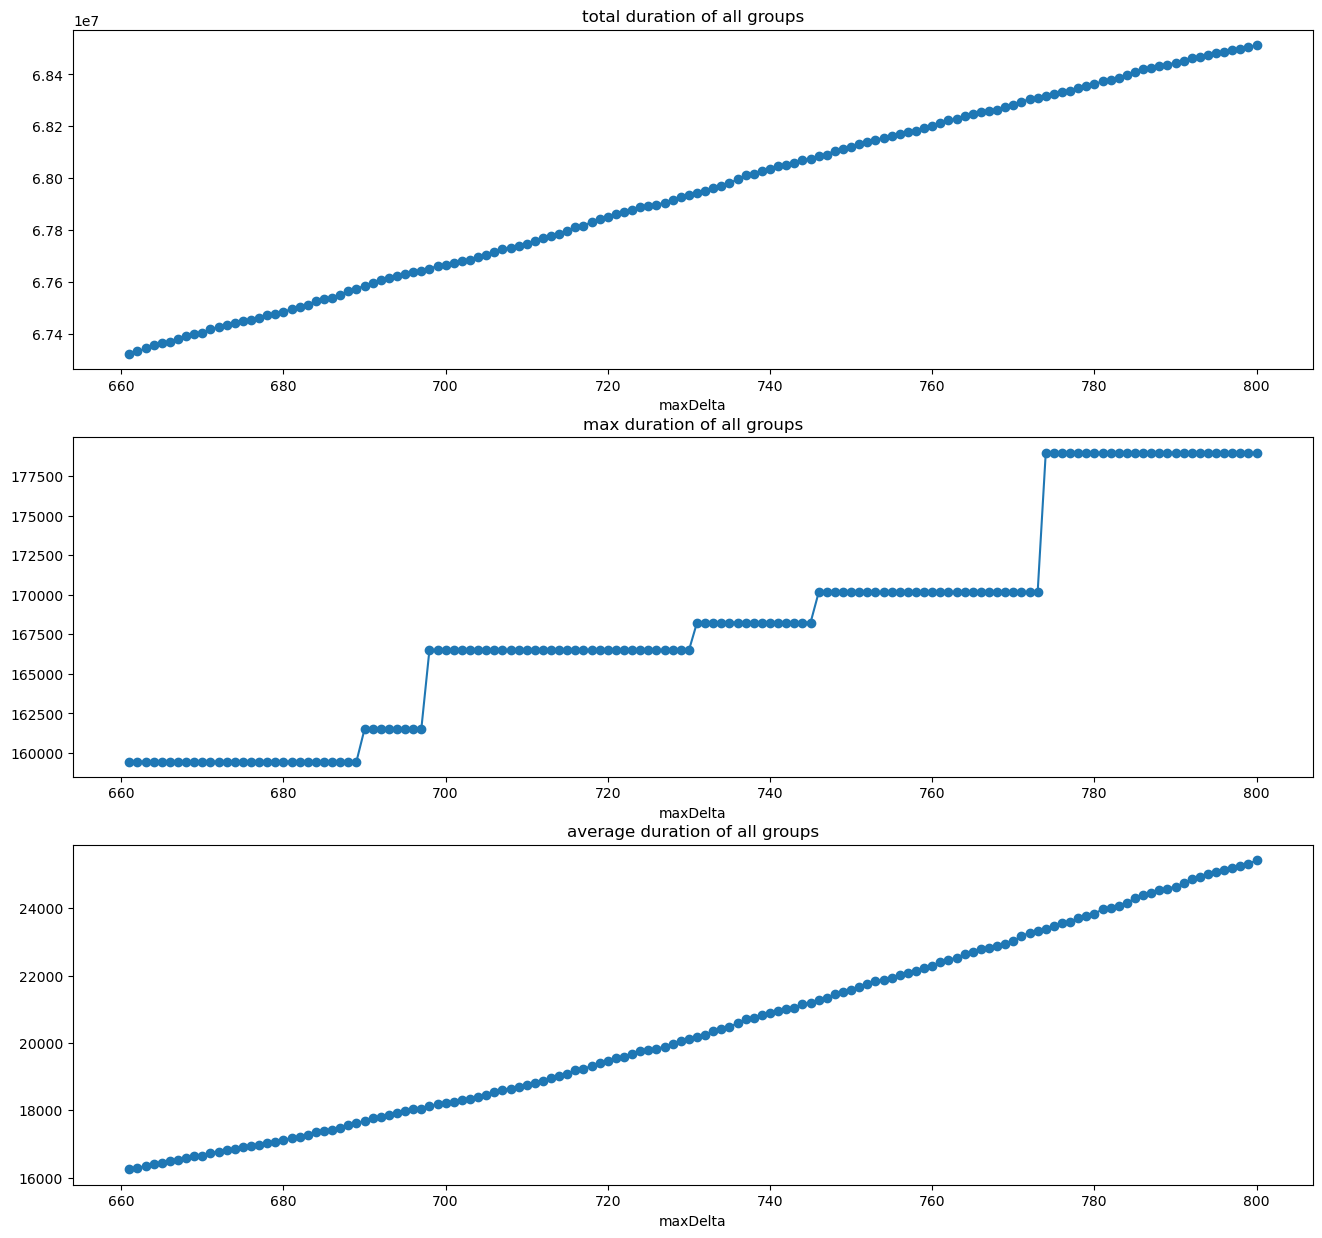

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(16, 15))
axs[0].set_title('total duration of all groups')
axs[0].plot(list(dataod.keys())[660:], total_durations[660:], marker='o')
axs[0].set_xlabel('maxDelta')
axs[1].set_title('max duration of all groups')
axs[1].plot(list(dataod.keys())[660:], longest_durations[660:], marker='o')
axs[1].set_xlabel('maxDelta')
axs[2].set_title('average duration of all groups')
axs[2].plot(list(dataod.keys())[660:], average_durations[660:], marker='o')
axs[2].set_xlabel('maxDelta')